E 0; L 2.221801; Tr_acc 0.173697; Te_acc 0.243078; T 1.448606
E 20; L 1.553854; Tr_acc 0.455655; Te_acc 0.448774; T 0.830189
E 40; L 1.398518; Tr_acc 0.512228; Te_acc 0.482991; T 0.827674
E 60; L 1.302057; Tr_acc 0.546048; Te_acc 0.506725; T 0.826466
E 80; L 1.229392; Tr_acc 0.569090; Te_acc 0.513153; T 0.824441
Tr_acc 0.595085; Te_acc 0.526206


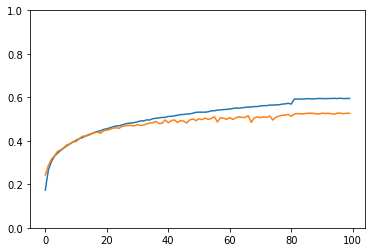

In [1]:
from mxnet import gluon
from mxnet.gluon import nn
from mxnet import autograd
from mxnet import nd
import numpy as np
import pickle as p
import mxnet as mx
import matplotlib.pyplot as plt
from time import time
ctx = mx.gpu()

def load_cifar(route = '/home/sinyer/python/data/cifar-10-batches-py', train_num = 50000, test_num = 10000):
    def load_batch(filename):
        with open(filename, 'rb')as f:
            data_dict = p.load(f, encoding='latin1')
            X = data_dict['data']
            Y = data_dict['labels']
            X = X.reshape(10000, 3, 32,32).astype("float")
            Y = np.array(Y)
            return X, Y
    def load_labels(filename):
        with open(filename, 'rb') as f:
            label_names = p.load(f, encoding='latin1')
            names = label_names['label_names']
            return names
    label_names = load_labels(route + "/batches.meta")
    x1, y1 = load_batch(route + "/data_batch_1")
    x2, y2 = load_batch(route + "/data_batch_2")
    x3, y3 = load_batch(route + "/data_batch_3")
    x4, y4 = load_batch(route + "/data_batch_4")
    x5, y5 = load_batch(route + "/data_batch_5")
    test_pic, test_label = load_batch(route + "/test_batch")
    train_pic = np.concatenate((x1, x2, x3, x4, x5))
    train_label = np.concatenate((y1, y2, y3, y4, y5))
    train_pic = train_pic[:train_num].astype('float32')/255
    train_label = train_label[:train_num].astype('float32')
    test_pic = test_pic[:test_num].astype('float32')/255
    test_label = test_label[:test_num].astype('float32')
    return train_pic, train_label, test_pic, test_label

train_pic, train_label, test_pic, test_label = load_cifar()

batch_size = 128
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(train_pic, train_label), batch_size, shuffle=True)
test_data = gluon.data.DataLoader(gluon.data.ArrayDataset(test_pic, test_label), batch_size, shuffle=False)


def accuracy(output, label):
    return nd.mean(output.argmax(axis=1)==label).asscalar()

def evaluate_accuracy(data_iterator, net, ctx):
    acc = 0.
    for data, label in data_iterator:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        acc += accuracy(output, label)
    return acc / len(data_iterator)

def relu(x):
    return nd.maximum(x, 0)

def net(x):
    x = x.reshape((-1, inp))
    h1 = relu(nd.dot(x, w1) + b1)
    output = nd.dot(h1, w2) + b2
    return output


n, inp, h, out = 50000, 3072, 128, 10
weight_scale = .01

w1 = nd.random_normal(shape=(inp, h), scale=weight_scale, ctx=ctx)
b1 = nd.zeros(h, ctx=ctx)
w2 = nd.random_normal(shape=(h, out), scale=weight_scale, ctx=ctx)
b2 = nd.zeros(out, ctx=ctx)

params = [w1, b1, w2, b2]
for param in params:
    param.attach_grad()

loss = gluon.loss.SoftmaxCrossEntropyLoss()


lr = 0.01 / batch_size
epochs = 100

a = []
b = []
for epoch in range(epochs):
    if epoch > 80:
        lr = 0.001 / batch_size
    train_loss = 0.
    train_acc = 0.
    batch = 0
    start = time()
    for data, label in train_data:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            l = loss(output, label)
        l.backward()
        for param in params:
            param[:] = param - lr * param.grad
        train_loss += nd.mean(l).asscalar()
        train_acc += accuracy(output, label)
        batch += 1
    a.append(train_acc/batch)
    test_acc = evaluate_accuracy(test_data, net, ctx)
    b.append(test_acc)
    if epoch%20 == 0:
        print("E %d; L %f; Tr_acc %f; Te_acc %f; T %f" % (epoch, train_loss / batch, train_acc / batch, test_acc, time() - start))
print("Tr_acc %f; Te_acc %f" % (train_acc / batch, test_acc))
plt.plot(np.arange(0, epochs),a,np.arange(0, epochs),b)
plt.ylim(0,1)
plt.show()